# Yardstick Example

This example notebook provides a simple example of how you can use the Yardstick benchmark to collect performance metrics from Minecraft-like games and how to evaluate their performance.

## Running an experiment

The cell below shows you how to run a simple experiment.

In [1]:
from yardstick_benchmark.provisioning import Das
from yardstick_benchmark.monitoring import Telegraf
from yardstick_benchmark.games.minecraft.server import PaperMC
from yardstick_benchmark.games.minecraft.workload import WalkAround
import yardstick_benchmark
from time import sleep
from datetime import datetime
from pathlib import Path
import os
import shutil

dest = Path(f"/var/scratch/{os.getlogin()}/yardstick/output")
if dest.exists():
    shutil.rmtree(dest)

### DEPLOYMENT ENVIRONMENT ###

# The DAS compute cluster is a medium-sized cluster for research and education.
# We use it in this example to provision bare-metal machines to run our performance
# evaluation.
das = Das()
# We reserve 2 nodes.
nodes = das.provision(num=2)

try:
    # Just in case, we remove data that may have been left from a previous run.
    yardstick_benchmark.clean(nodes)

    ### METRICS ###

    # Telegraf (https://www.influxdata.com/time-series-platform/telegraf/)
    # is the metric collection tool we use to collect performance metrics from the
    # nodes and any applications deployed on these nodes.
    telegraf = Telegraf(nodes)
    # We plan to deploy our Minecraft-like game server on node 0.
    # To obtain application level metrics from the game server,
    # the next two lines configure node 0 to run additional metric collection
    # tools.
    telegraf.add_input_jolokia_agent(nodes[0])
    telegraf.add_input_execd_minecraft_ticks(nodes[0])
    # Perform the actual deployment of Telegraf.
    # This includes downloading the Telegraf executable and preparing configuration
    # files.
    res = telegraf.deploy()
    # Start Telegraf on all remote nodes.
    telegraf.start()

    ### System Under Test (SUT) ###

    # PaperMC (https://papermc.io/) is the Minecraft-like game whose performance
    # we'll evaluate in this example.
    # We pass a list with all the nodes on which we want to deploy a server.
    # In this example, we only deploy a server on node 0.
    papermc = PaperMC(nodes[:1])
    # We perform the deployment, including downloading the game executable JAR and
    # correctly configuring the game's configuration file.
    papermc.deploy()
    # We start the game server.
    papermc.start()

    ### WORKLOAD ###

    wl = WalkAround(nodes[1:], nodes[0].host, bots_per_node=10)
    wl.deploy()
    wl.start()

    sleep_time = 60
    print(f"sleeping for {sleep_time} seconds")
    sleep(sleep_time)

    papermc.stop()
    papermc.cleanup()

    telegraf.stop()
    telegraf.cleanup()

    yardstick_benchmark.fetch(dest, nodes)
finally:
    yardstick_benchmark.clean(nodes)
    das.release(nodes)



PLAY [Clean data from nodes] ***************************************************

TASK [Gathering Facts] *********************************************************
ok: [node015]
ok: [node001]

TASK [Remove data from nodes] **************************************************
ok: [node001]
ok: [node015]

PLAY RECAP *********************************************************************
node001                    : ok=2    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
node015                    : ok=2    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   

PLAY [Deploy Telegraf] *********************************************************

TASK [Gathering Facts] *********************************************************
ok: [node015]
ok: [node001]

TASK [Create Telegraf directory] ***********************************************
changed: [node001]
changed: [node015]

TASK [Download Telegraf] ******************************************

## Data Pre-Processing

In [1]:
import glob
import pandas as pd

raw_data_files = glob.glob(f"{dest}/**/metrics-*.csv", recursive=True)
print(raw_data_files)

for raw_data_file in raw_data_files:
    metrics_file = Path(raw_data_file)
    keys = {}
    with open(metrics_file) as fin:
        for line in fin:
            first_delim = line.find(",")
            second_delim = line.find(",", first_delim+1)
            key = line[first_delim+1:second_delim]
            if key not in keys:
                keys[key] = open(metrics_file.parent / f"{key}.csv", "w+")
            keys[key].write(line)
    for key, fd in keys.items():
        fd.close()

NameError: name 'dest' is not defined

## Visualizing Results

<Axes: xlabel='Time [m]', ylabel='CPU utilization [%]'>

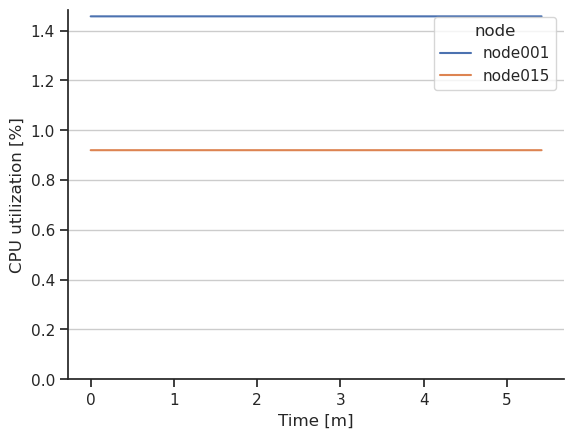

In [10]:
import seaborn as sns

dfs = []
for cpu_file in glob.glob(f"{dest}/**/cpu.csv", recursive=True):
    df = pd.read_csv(cpu_file, names = ["timestamp","measurement","core_id","cpu","host","physical_id","time_active","time_guest","time_guest_nice","time_idle","time_iowait","time_irq","time_nice","time_softirq","time_steal","time_system","time_user"])
    df["node"] = Path(cpu_file).parent.parent.name
    df["timestamp"] = df["timestamp"].transform(lambda x: x - x.min())
    df["timestamp_m"] = df["timestamp"] / 60
    df = df[df.cpu == "cpu-total"]
    df['time_total'] = df.time_active + df.time_idle
    df['util'] = 100 * df.time_active / df.time_total
    df = df.sort_values("util", ascending=False).drop_duplicates(subset=["timestamp", "cpu"], keep="first")
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.head()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.lineplot(df, x="timestamp_m", y="util", hue="node")
ax.grid(axis="y")
ax.set_ylim(bottom=0)
ax.set_ylabel("CPU utilization [%]")
ax.set_xlabel("Time [m]")
ax



<Axes: xlabel='Time [m]', ylabel='Tick duration [ms]'>

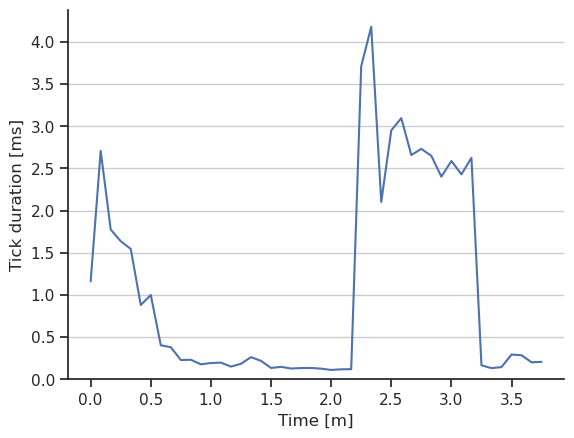

In [11]:
# timestamp,measurement,cpu,host,usage_guest,usage_guest_nice,usage_idle,usage_iowait,usage_irq,usage_nice,usage_softirq,usage_steal,usage_system,usage_user
tick_times_file = glob.glob(f"{dest}/**/minecraft_tick_times.csv", recursive=True)[0]

df = pd.read_csv(tick_times_file, names = ["timestamp", "label", "node", "jolokia_endpoint", "tick_duration_ms"])
df["timestamp"] = df["timestamp"].transform(lambda x: x - x.min())
df["timestamp_m"] = df["timestamp"] / 60
df.head()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.lineplot(df, x="timestamp_m", y="tick_duration_ms")
ax.grid(axis="y")
ax.set_ylim(bottom=0)
ax.set_ylabel("Tick duration [ms]")
ax.set_xlabel("Time [m]")
ax